In [1]:
import os
import pandas as pd
import fuzzymatcher
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_sb = os.path.join(base_dir, 'data', 'sb')
data_dir_wyscout = os.path.join(base_dir, 'data', 'wyscout')
data_dir_sb_wyscout = os.path.join(base_dir, 'data', 'sb-wyscout')
scripts_dir = os.path.join(base_dir, 'scripts')
scripts_dir_sb = os.path.join(base_dir, 'scripts', 'sb')
scripts_dir_wyscout = os.path.join(base_dir, 'scripts', 'wyscout')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
fig_dir_sb = os.path.join(base_dir, 'img', 'fig', 'sb')
fig_dir_wyscout = os.path.join(base_dir, 'img', 'fig', 'wyscout')
video_dir = os.path.join(base_dir, 'video')

Load the data

In [4]:
WYSCOUT = os.path.join(data_dir_wyscout, 'raw')
STATSBOMB = os.path.join(data_dir_sb, 'raw')

In [5]:
STATSBOMB_SHOTS = os.path.join(STATSBOMB, 'shots.csv')
WYSCOUT_SHOTS = os.path.join(WYSCOUT, 'shots.csv')
FREEZE_FEATURES = os.path.join(STATSBOMB, 'freeze_features.csv')
df_statsbomb_shots = pd.read_csv(STATSBOMB_SHOTS)
df_wyscout_shots = pd.read_csv(WYSCOUT_SHOTS)
df_freeze_frame = pd.read_csv(FREEZE_FEATURES)

Remove three shots without player info

In [6]:
df_wyscout_shots = df_wyscout_shots[df_wyscout_shots.player_id.notnull()].copy()

Get a unique team id by combining the datasets and using a fuzzy match on team name

In [7]:
cols = ['team_id', 'team_name', 'competition_gender']
a = df_wyscout_shots[cols].drop_duplicates('team_id', keep='last').rename({'team_id': 'wyscout_team_id'}, axis=1).copy()
b = df_statsbomb_shots[cols].drop_duplicates('team_id', keep='last').rename({'team_id': 'statsbomb_team_id'}, axis=1).copy()
team_match = fuzzymatcher.fuzzy_left_join(a,
                                          b,
                                          left_on=['team_name', 'competition_gender'],
                                          right_on=['team_name', 'competition_gender'],
                                          left_id_col='wyscout_team_id',
                                          right_id_col='statsbomb_team_id')
team_match = team_match[(team_match.best_match_score > 0.02) & (team_match.competition_gender_right == 'male')].copy()
team_match = (team_match[['wyscout_team_id', 'statsbomb_team_id', 'competition_gender_right', 'team_name_right']]
              .rename({'team_name_right': 'team_name', 'competition_gender_right': 'competition_gender'}, axis=1)
              .copy())
df_team = pd.concat([a[~a.wyscout_team_id.isin(team_match.wyscout_team_id)],
                     b[~b.statsbomb_team_id.isin(team_match.statsbomb_team_id)],
                     team_match])
df_team.reset_index(drop=True, inplace=True)
df_team.index.name = 'team_id'
df_team.reset_index(inplace=True)

Add the unique team_id/ name to the datasets

In [8]:
# wyscout
a = df_team[['team_id', 'wyscout_team_id', 'team_name']].copy()
df_wyscout_shots.rename({'team_id': 'wyscout_team_id'}, axis=1, inplace=True)
df_wyscout_shots.drop('team_name', axis=1, inplace=True)
df_wyscout_shots = df_wyscout_shots.merge(a, how='left', on='wyscout_team_id')
# statsbomb
b = df_team[['team_id', 'statsbomb_team_id', 'team_name']].copy()
df_statsbomb_shots.rename({'team_id': 'statsbomb_team_id'}, axis=1, inplace=True)
df_statsbomb_shots.drop('team_name', axis=1, inplace=True)
df_statsbomb_shots = df_statsbomb_shots.merge(b, how='left', on='statsbomb_team_id')

Get a unique player id

In [9]:
# get a dataframe of statsbomb players
cols = ['player_id', 'team_id', 'team_name', 'firstName', 'middleName', 'lastName', 'Name', 'competition_gender']
statsbomb_players = df_statsbomb_shots[cols].drop_duplicates('player_id').copy()
statsbomb_players.rename({'player_id': 'player_id_statsbomb'}, axis=1, inplace=True)
# get a dataframe of wyscout players
wyscout_players = df_wyscout_shots[cols].drop_duplicates('player_id').copy()
wyscout_players.rename({'player_id': 'player_id_wyscout'}, axis=1, inplace=True)

In [10]:
# merge the two datasets: exact match on names
exact_match = wyscout_players.merge(statsbomb_players, how='inner', 
                                    on=['firstName', 'middleName', 'lastName', 'Name'],
                                    suffixes=['_wyscout', '_statsbomb'])
print('Check no duplicates:', exact_match.player_id_wyscout.duplicated().sum(), 
      exact_match.player_id_statsbomb.duplicated().sum())
exact_match = exact_match[['player_id_wyscout', 'player_id_statsbomb', 'firstName', 'middleName', 'lastName', 'Name']].copy()

Check no duplicates: 0 0


In [11]:
# for the unmatched use a fuzzy match to match on names
not_matched_statsbomb = statsbomb_players[~statsbomb_players.player_id_statsbomb.isin(exact_match.player_id_statsbomb)].copy()
not_matched_wyscout = wyscout_players[~wyscout_players.player_id_wyscout.isin(exact_match.player_id_wyscout)].copy()
fuzzy_match = fuzzymatcher.fuzzy_left_join(not_matched_wyscout,
                                           not_matched_statsbomb,
                                           left_on=['Name'],
                                           right_on=['Name'],
                                           left_id_col='player_id_wyscout',
                                           right_id_col='player_id_statsbomb')
fuzzy_match.sort_values('best_match_score', ascending=False, inplace=True)
fuzzy_match.drop_duplicates('player_id_wyscout', keep='first', inplace=True)
fuzzy_match.drop_duplicates('player_id_statsbomb', keep='first', inplace=True)
# drop some dodgy matches just above the threshold (hand checked)
fuzzy_match = fuzzy_match[(fuzzy_match.best_match_score > 0.25)  & 
                          (fuzzy_match.competition_gender_left == fuzzy_match.competition_gender_right) & 
                          (~fuzzy_match.player_id_statsbomb.isin([23804, 40366, 40257]))].copy()

In [12]:
# concatenate all the matches
fuzzy_match = fuzzy_match[['player_id_wyscout', 'player_id_statsbomb', 'firstName_right',
                           'middleName_right', 'lastName_right', 'Name_right']].copy()
fuzzy_match.rename({'firstName_right': 'firstName', 'middleName_right': 'middleName',
                    'lastName_right': 'lastName', 'Name_right': 'Name'}, axis=1, inplace=True)
matches = pd.concat([fuzzy_match, exact_match])
# add the non-matches
not_matched_wyscout = wyscout_players[~wyscout_players.player_id_wyscout.isin(matches.player_id_wyscout)].copy()
not_matched_statsbomb = statsbomb_players[~statsbomb_players.player_id_statsbomb.isin(matches.player_id_statsbomb)].copy()
all_players = pd.concat([matches, not_matched_wyscout, not_matched_statsbomb])
all_players.drop(['team_id', 'team_name', 'competition_gender'], axis=1, inplace=True)
all_players.reset_index(drop=True, inplace=True)
all_players.index.name = 'player_id'
all_players.reset_index(inplace=True)

Add unique player id/ Names to datasets

In [13]:
# merge statsbomb
df_statsbomb_shots.drop(['firstName', 'middleName', 'lastName', 'Name'], axis=1, inplace=True)
df_statsbomb_shots.rename({'player_id': 'player_id_statsbomb'}, axis=1, inplace=True)
df_statsbomb_shots = df_statsbomb_shots.merge(all_players.drop('player_id_wyscout', axis=1),
                                              on='player_id_statsbomb', how='left')
# merge wyscout
df_wyscout_shots.drop(['firstName', 'middleName', 'lastName', 'Name'], axis=1, inplace=True)
df_wyscout_shots.rename({'player_id': 'player_id_wyscout'}, axis=1, inplace=True)
df_wyscout_shots = df_wyscout_shots.merge(all_players.drop('player_id_statsbomb', axis=1),
                                          on='player_id_wyscout', how='left')

Merge freeze frame features

In [14]:
df_statsbomb_shots = df_statsbomb_shots.merge(df_freeze_frame, on='id', how='left')

Concatenate shot datasets

In [15]:
df_statsbomb_shots['dataset'] = 'statsbomb'
df_wyscout_shots.rename({'id': 'wyscout_id'}, axis=1, inplace=True)
df_wyscout_shots['dataset'] = 'wyscout'
df_statsbomb_shots.rename({'id': 'statsbomb_id'}, axis=1, inplace=True)
df_all_shots = pd.concat([df_statsbomb_shots, df_wyscout_shots], axis=0)

Pass technique name to 'other' if null

In [16]:
df_all_shots.loc[(df_all_shots.pass_technique_name.isnull()) &
                 (df_all_shots.assist_type == 'pass'), 'pass_technique_name'] = 'other'

Shot heatmap

In [17]:
print('Number of shots:', len(df_all_shots), ';Number of goals:', df_all_shots.goal.sum())

Number of shots: 67601 ;Number of goals: 7191


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


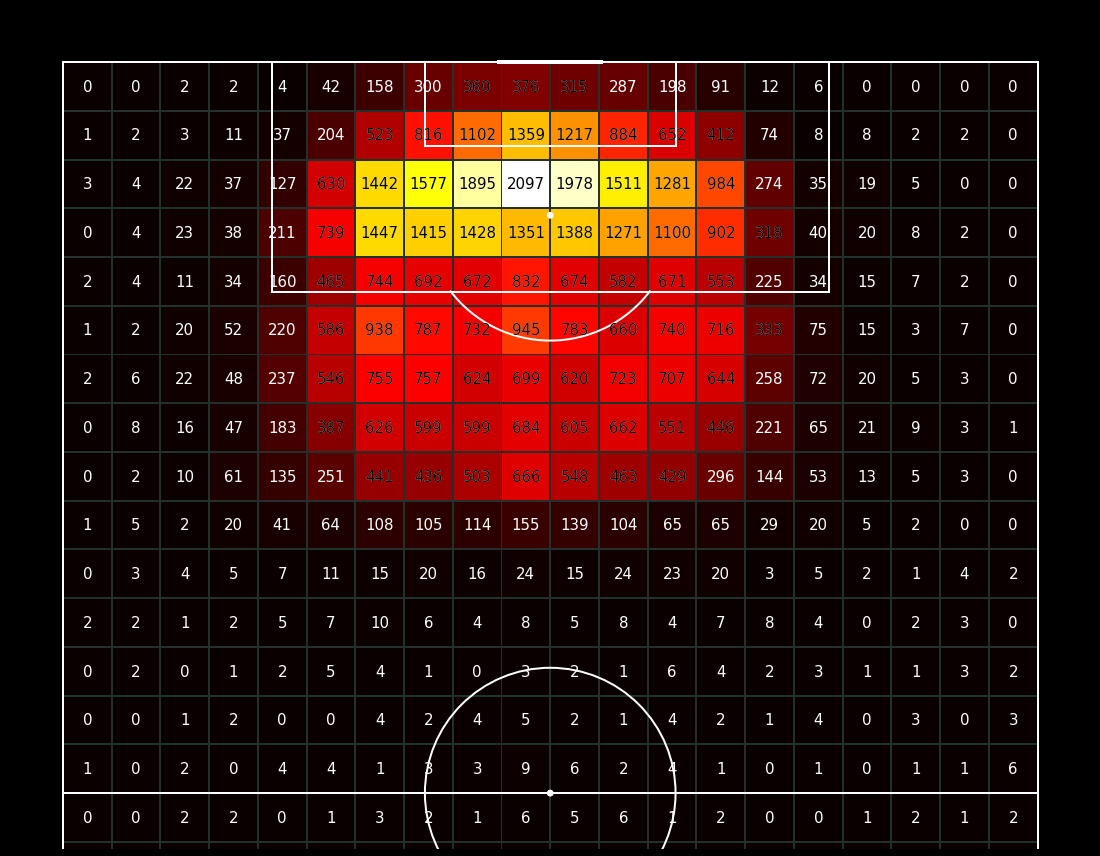

In [19]:
plt.style.use('dark_background')
pitch = Pitch(pitch_type='stats', figsize=(16, 12), orientation='vertical', view='half', line_zorder=2)
fig, ax = pitch.draw()
bs = pitch.bin_statistic(df_all_shots.x, df_all_shots.y, statistic='count', bins=(30, 20))
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = (bs['statistic']).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 300
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
#fig.savefig(os.path.join('..', '..', 'figures', '17_number_of_shots_by_location.png'),
#            bbox_inches = 'tight', pad_inches = 0.2)

Create ID column

In [20]:
df_all_shots['shot_id'] = df_all_shots.index + 1

Save dataset

In [21]:
df_all_shots.reset_index(drop=True, inplace=True)

In [22]:
df_all_shots.to_csv(os.path.join(data_dir_sb_wyscout, 'shots.csv'))

Info

In [23]:
df_all_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67601 entries, 0 to 67600
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0_x            22317 non-null  float64
 1   match_id                67601 non-null  int64  
 2   statsbomb_id            22317 non-null  object 
 3   eventSec                67601 non-null  float64
 4   period                  67601 non-null  int64  
 5   goal                    67601 non-null  bool   
 6   statsbomb_team_id       22317 non-null  float64
 7   player_id_statsbomb     22317 non-null  float64
 8   shot_type_name          67601 non-null  object 
 9   x                       67601 non-null  float64
 10  y                       67601 non-null  float64
 11  counter_attack          67601 non-null  bool   
 12  fast_break              67601 non-null  bool   
 13  strong_foot             67601 non-null  bool   
 14  body_part_name          67601 non-null

Compare datasets

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0.5, 1.0, 'Wyscout')

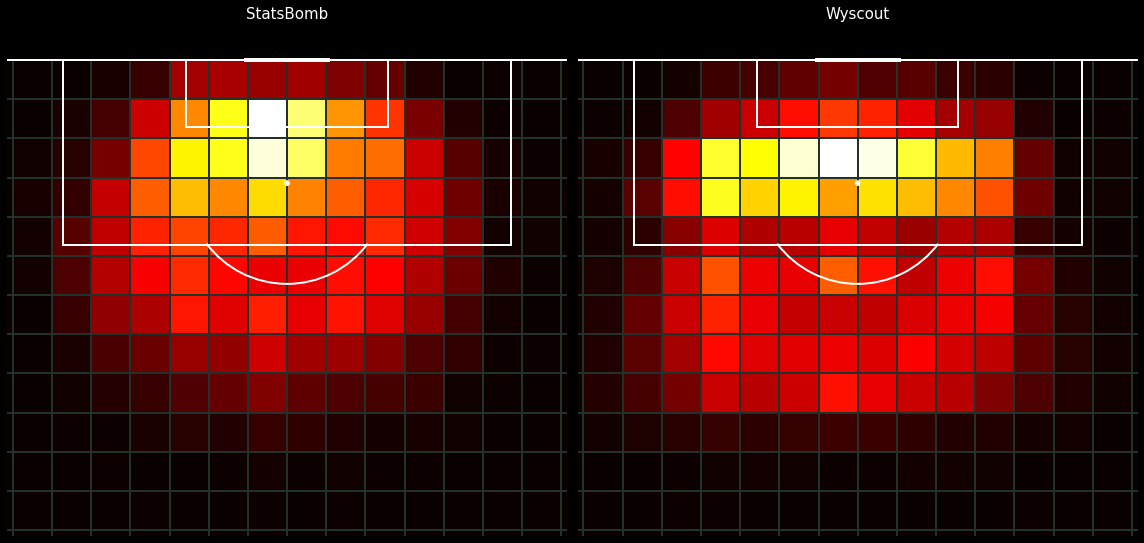

In [24]:
pitch = Pitch(pitch_type='stats', figsize=(16, 12), layout=(1, 2), pad_left=-10, pad_right=-10, pad_bottom=-10,
              orientation='vertical', view='half', line_zorder=2)
fig, ax = pitch.draw()
ax = ax.ravel()
bs = pitch.bin_statistic(df_all_shots[df_all_shots.dataset=='statsbomb'].x,
                         df_all_shots[df_all_shots.dataset=='statsbomb'].y, 
                         statistic='count', bins=(30, 20))
bs['statistic'] = (bs['statistic']).astype(np.int32)
pcm = pitch.heatmap(bs, ax=ax[0], cmap='hot', edgecolors='#22312b')
ax[0].set_title('StatsBomb', fontsize=15, pad=-4)
bs = pitch.bin_statistic(df_all_shots[df_all_shots.dataset=='wyscout'].x,
                         df_all_shots[df_all_shots.dataset=='wyscout'].y,
                         statistic='count', bins=(30, 20))
bs['statistic'] = (bs['statistic']).astype(np.int32)
pcm = pitch.heatmap(bs, ax=ax[1], cmap='hot', edgecolors='#22312b')
ax[1].set_title('Wyscout', fontsize=15, pad=-4)

In [25]:
df_all_shots.groupby('dataset').fast_break.mean()

dataset
statsbomb    0.033517
wyscout      0.041803
Name: fast_break, dtype: float64

In [26]:
df_all_shots.groupby('dataset').counter_attack.mean()

dataset
statsbomb    0.047005
wyscout      0.053065
Name: counter_attack, dtype: float64

In [27]:
df_all_shots.groupby('dataset').visible_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,22317.0,0.464159,0.297529,0.0,0.272875,0.359457,0.560685,3.141593
wyscout,45284.0,0.403722,0.248600,0.0,0.244729,0.316877,0.491420,3.141593


In [28]:
df_all_shots.groupby('dataset').middle_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,22317.0,0.496851,0.329559,0.000000,0.224889,0.459831,0.726642,1.570796
wyscout,45284.0,0.484218,0.313208,0.005017,0.225812,0.452154,0.699404,1.570796


In [29]:
df_all_shots.groupby('dataset').distance_to_goal.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,22317.0,16.765658,7.759724,0.6,10.6,15.9,22.3,70.4
wyscout,45284.0,19.074307,8.376332,0.4,12.6,17.9,25.6,74.9


In [30]:
df_all_shots.groupby('dataset').distance_visible_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,22317.0,6.080915,1.164912,0.0,5.575534,6.437036,6.953032,7.309511
wyscout,45284.0,6.155667,1.104898,0.0,5.679082,6.512238,6.978229,9.424778


In [31]:
df_all_shots.groupby('dataset').pass_switch.value_counts()

dataset    pass_switch
statsbomb  False          14849
           True            1016
wyscout    False          27961
           True            2158
Name: pass_switch, dtype: int64

In [32]:
df_all_shots.groupby('dataset').pass_cut_back.value_counts()

dataset    pass_cut_back
statsbomb  False            15444
           True               421
wyscout    False            29114
           True              1005
Name: pass_cut_back, dtype: int64

In [33]:
df_all_shots.groupby('dataset').pass_cross.value_counts()

dataset    pass_cross
statsbomb  False         12831
           True           3034
wyscout    False         22397
           True           7722
Name: pass_cross, dtype: int64

In [34]:
df_all_shots.smart_pass.value_counts()

False    27628
True      2491
Name: smart_pass, dtype: int64

In [35]:
df_all_shots.groupby('dataset').assist_type.value_counts()

dataset    assist_type
statsbomb  pass           15865
           recovery        2136
           clearance       1802
           direct          1330
           rebound         1184
wyscout    pass           30119
           recovery        6929
           rebound         3510
           clearance       2517
           direct          2209
Name: assist_type, dtype: int64

In [36]:
df_all_shots.groupby('dataset').shot_type_name.value_counts()

dataset    shot_type_name  
statsbomb  open_play           14669
           corner               2637
           throw_in             2081
           free_kick            1600
           direct_set_piece     1330
wyscout    open_play           30897
           corner               5542
           throw_in             4444
           direct_set_piece     2209
           free_kick            2192
Name: shot_type_name, dtype: int64

Source: https://www.youtube.com/watch?v=2RhTuRWNqUc

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

In [ ]:
def draw_pitch(x_min=0, x_max=105,
               y_min=0, y_max=68,
               pitch_color="w",
               line_color="grey",
               line_thickness=1.5,
               point_size=20,
               orientation="horizontal",
               aspect="full",
               ax=None
               ):

    if not ax:
        raise TypeError("This function is intended to be used with an existing fig and ax in order to allow flexibility in plotting of various sizes and in subplots.")


    if orientation.lower().startswith("h"):
        first = 0
        second = 1
        arc_angle = 0

        if aspect == "half":
            ax.set_xlim(x_max / 2, x_max + 5)

    elif orientation.lower().startswith("v"):
        first = 1
        second = 0
        arc_angle = 90

        if aspect == "half":
            ax.set_ylim(x_max / 2, x_max + 5)

    
    else:
        raise NameError("You must choose one of horizontal or vertical")

    
    ax.axis("off")

    rect = plt.Rectangle((x_min, y_min),
                         x_max, y_max,
                         facecolor=pitch_color,
                         edgecolor="none",
                         zorder=-2)

    ax.add_artist(rect)

    x_conversion = x_max / 100
    y_conversion = y_max / 100

    pitch_x = [0,5.8,11.5,17,50,83,88.5,94.2,100] # pitch x markings
    pitch_x = [x * x_conversion for x in pitch_x]

    pitch_y = [0, 21.1, 36.6, 50, 63.2, 78.9, 100] # pitch y markings
    pitch_y = [x * y_conversion for x in pitch_y]

    goal_y = [45.2, 54.8] # goal posts
    goal_y = [x * y_conversion for x in goal_y]

    # side and goal lines
    lx1 = [x_min, x_max, x_max, x_min, x_min]
    ly1 = [y_min, y_min, y_max, y_max, y_min]

    # outer boxed
    lx2 = [x_max, pitch_x[5], pitch_x[5], x_max]
    ly2 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    lx3 = [0, pitch_x[3], pitch_x[3], 0]
    ly3 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    # goals
    lx4 = [x_max, x_max+2, x_max+2, x_max]
    ly4 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    lx5 = [0, -2, -2, 0]
    ly5 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    # 6 yard boxes
    lx6 = [x_max, pitch_x[7], pitch_x[7], x_max]
    ly6 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]

    lx7 = [0, pitch_x[1], pitch_x[1], 0]
    ly7 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]


    # Halfway line, penalty spots, and kickoff spot
    lx8 = [pitch_x[4], pitch_x[4]]
    ly8 = [0, y_max]

    lines = [
        [lx1, ly1],
        [lx2, ly2],
        [lx3, ly3],
        [lx4, ly4],
        [lx5, ly5],
        [lx6, ly6],
        [lx7, ly7],
        [lx8, ly8],
        ]

    points = [
        [pitch_x[6], pitch_y[3]],
        [pitch_x[2], pitch_y[3]],
        [pitch_x[4], pitch_y[3]]
        ]

    circle_points = [pitch_x[4], pitch_y[3]]
    arc_points1 = [pitch_x[6], pitch_y[3]]
    arc_points2 = [pitch_x[2], pitch_y[3]]


    for line in lines:
        ax.plot(line[first], line[second],
                color=line_color,
                lw=line_thickness,
                zorder=-1)

    for point in points:
        ax.scatter(point[first], point[second],
                   color=line_color,
                   s=point_size,
                   zorder=-1)

    circle = plt.Circle((circle_points[first], circle_points[second]),
                        x_max * 0.088,
                        lw=line_thickness,
                        color=line_color,
                        fill=False,
                        zorder=-1)

    ax.add_artist(circle)

    arc1 = Arc((arc_points1[first], arc_points1[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=128.75,
               theta2=231.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc1)

    arc2 = Arc((arc_points2[first], arc_points2[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=308.75,
               theta2=51.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc2)

    ax.set_aspect("equal")

    return ax

In [ ]:
background = "#303640"

fig, ax = plt.subplots(figsize=(11, 7))
fig.set_facecolor(background)

draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color=background,
           line_color="lightgrey",
           ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
pitch_length_x = 104
pitch_length_y = 68

In [ ]:
df_liverpool_2019 = df_all_shots

In [ ]:
df_liverpool_2019['X'] = df_liverpool_2019['x']
df_liverpool_2019['Y'] = df_liverpool_2019['y']

In [ ]:
df_liverpool_2019

In [ ]:
# Add new columns

## Convert Understats coordinates from 0,100 to a range of x(0,104) and y(0,68) - the average pitch size.
df_liverpool_2019['XM'] = df_liverpool_2019['X'] * pitch_length_x
df_liverpool_2019['YM'] = df_liverpool_2019['Y'] * pitch_length_y

## Create reverse columns of previous created 'XM' and 'YM' columns
df_liverpool_2019['XM_r'] = pitch_length_x - df_liverpool_2019['XM']    # Added for completeness but not used
df_liverpool_2019['YM_r'] = pitch_length_y - df_liverpool_2019['YM']

## Create column of scaled xG to make them larger in the plot
#df_liverpool_2019['xG_s'] = df_liverpool_2019['xG'] * 1.5

In [ ]:
# Plotting Shots

## Draw the pitch
background = "#303640"

fig, ax = plt.subplots(figsize=(11, 7))
fig.set_facecolor(background)

draw_pitch(orientation="horizontal",
           aspect="fll",
           pitch_color=background,
           line_color="lightgrey",
           ax=ax)


import random

sample = 20

x = [random.randint(0, pitch_length_x) for p in range(0, sample)]
y = [random.randint(0, pitch_length_y) for p in range(0, sample)]

zo = 12

plt.scatter(x,y,marker='o',color='red',edgecolors="black", zorder=zo)
plt.show()

In [ ]:
x

In [ ]:
y

In [ ]:
# Plotting Shots

## Draw the pitch
background = "#303640"

fig, ax = plt.subplots(figsize=(11, 7))
fig.set_facecolor(background)

draw_pitch(orientation="horizontal",
           aspect="fll",
           pitch_color=background,
           line_color="lightgrey",
           ax=ax)


import random

sample = 20

# X and Y coordinates
x = df_liverpool_2019['XM'].tolist()
y = df_liverpool_2019['YM'].tolist()

zo = 12

plt.scatter(x,y,marker='o',color='red',edgecolors="black", zorder=zo)
plt.show()

In [ ]:
# Plotting Shots

## Draw the pitch
background = "#303640"

fig, ax = plt.subplots(figsize=(11, 7))
fig.set_facecolor(background)

draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color=background,
           line_color="lightgrey",
           ax=ax)


x = [random.randint(0, pitch_length_x) for p in range(0, sample)]
y = [random.randint(0, pitch_length_y) for p in range(0,sample)]

zo = 12

plt.scatter(x,y,marker='o',color='red',edgecolors="black", zorder=zo)
plt.show()

zo = 12

## X and Y coordinates
x = df_liverpool_2019['XM'].tolist()
y = df_liverpool_2019['YM'].tolist()
y1 = [68 - i for i in y]


## Add Z variable for xG
#z1 = [500 * i for i in z] # This is to scale the "xG" values for plotting


## Add small legend in the bottom corner
mSize = [0.05,0.10,0.2,0.4,0.6,1]
mSizeS = [500 * i for i in mSize]
mx = [5.5,7,9,11,13.5,16.5]
my = [60,60,60,60,60,60]

plt.text(11,55,
         #"xG",
         s=1,
         color="white",
         ha="center",
         va="center",
         zorder=zo,
         fontsize=16
        )

plt.scatter(y1,
            x,
            s=20,
            #s=z1,
            c="red",
            edgecolors="k",
            zorder=zo
           )
plt.scatter(mx,my, s=mSizeS, facecolors="white", edgecolor="white",zorder=zo)
plt.plot([5.5,17], [57,57],color="white",lw=2,zorder=zo)

i = 0

for i in range(len(mx)):
    plt.text(mx[i], my[i], mSize[i], fontsize=mSize[i]*18, color="#195905", zorder=zo,ha="center", va="center")

    
## Title
plt.title("All Shots")

## Show plot
plt.show()